<a href="https://colab.research.google.com/github/HenryZhao1412/diffusion_model_human_faces/blob/main/stable_diffusion_face_2_10_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow==9.0.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/"

Mounted at /content/drive
 archive	   'ENGG3800 TEAM 05 Seminar.gslides'   image_for_training   stable_diffusion
'Colab Notebooks'   image_dataset		        image_training	     training_images


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [ ]:
import torch
import numpy as np
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
import torchvision.utils

In [ ]:
def show_images(x):
    x = x * 0.5 + 0.5
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torchvision
from datasets import load_dataset
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

dataset = load_dataset("imagefolder", data_dir="/content/drive/My Drive/training_images", split="train")

Resolving data files:   0%|          | 0/6617 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
image_size = 128
batch_size = 32
num_epoch = 60
learning_rate = 1e-4

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
  images = [preprocess(image.convert("RGB")) for image in examples["image"]]
  return {"images": images}

dataset.set_transform(transform)
print(dataset)

train_dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=False
)

Dataset({
    features: ['image'],
    num_rows: 6617
})


X shape: torch.Size([8, 3, 128, 128])


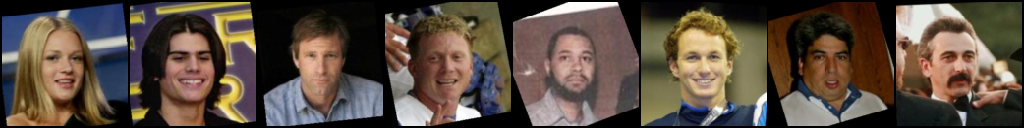

In [ ]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * image_size, image_size), resample=Image.NEAREST)

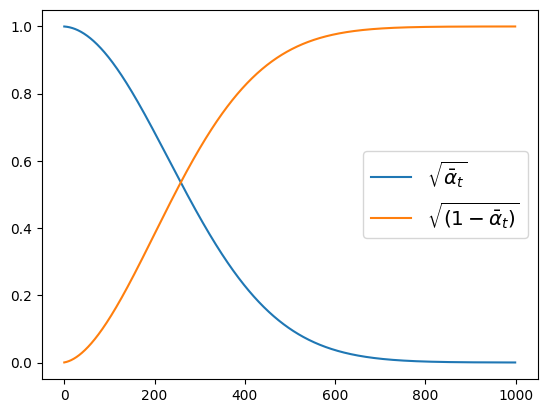

In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.9, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.9, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

Noisy X shape torch.Size([8, 3, 128, 128])


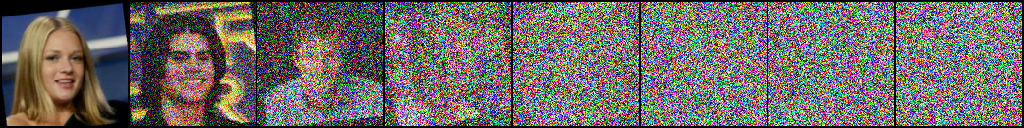

In [ ]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * image_size, image_size), resample=Image.NEAREST)

In [ ]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 256, 256, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)
model.to(device);
model

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Dow

In [ ]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 128, 128])

In [ ]:
print("Now")

Now


In [ ]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
losses = []

for epoch in range(num_epoch):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")


Epoch:5, loss: 0.02880385272870749
Epoch:10, loss: 0.023991615916399853
Epoch:15, loss: 0.02394890859003228
Epoch:20, loss: 0.022860961624281705
Epoch:25, loss: 0.02253418957931552
Epoch:30, loss: 0.022539859448654064
Epoch:35, loss: 0.02177996359369605
Epoch:40, loss: 0.022377569277901292
Epoch:45, loss: 0.020917404942430447
Epoch:50, loss: 0.021003458608427773
Epoch:55, loss: 0.02015896633285399
Epoch:60, loss: 0.020324254610940166


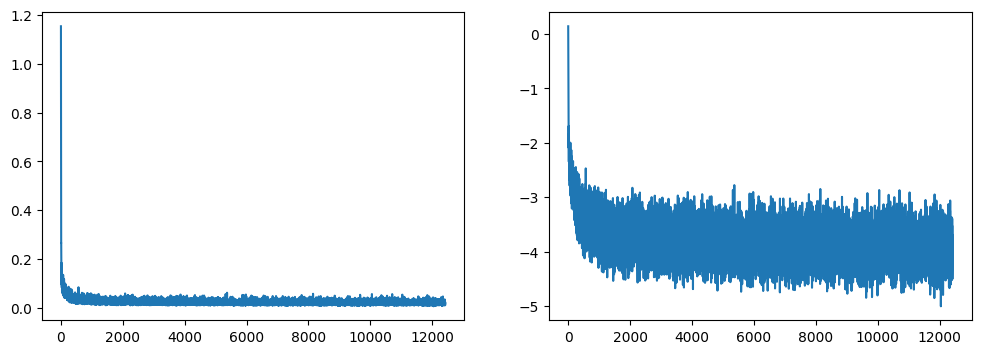

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

In [ ]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

In [ ]:
from huggingface_hub import HfApi, create_repo, get_full_repo_name

model_name = "stable_diffusion_face_generation_10.26"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'HengJi/stable_diffusion_face_generation_10.26'

In [ ]:
image_pipe.save_pretrained("my_pipeline_4")

In [ ]:
create_repo(hub_model_id)

api = HfApi()
api.upload_folder(
    folder_path="my_pipeline_4/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(folder_path="my_pipeline_4/unet", path_in_repo="", repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj="my_pipeline_4/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

diffusion_pytorch_model.safetensors:   0%|          | 0.00/296M [00:00<?, ?B/s]

'https://huggingface.co/HengJi/stable_diffusion_face_generation_10.26/blob/main/model_index.json'

In [ ]:
from huggingface_hub import ModelCard

content = "HengJi's faces generation model"

card = ModelCard(content)
card.push_to_hub(hub_model_id)

Repo card metadata block was not found. Setting CardData to empty.


'https://huggingface.co/HengJi/stable_diffusion_face_generation_10.26/blob/main/README.md'

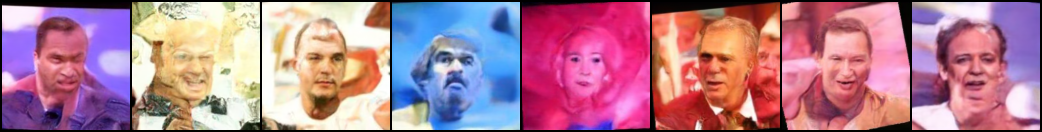

In [ ]:
sample = torch.randn(8, 3, 128, 128).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

  with torch.no_grad():
    residual = model(sample, t).sample

  sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)